Umgebung einrichten
===
- Installiere die notwendigen Pakete
- Importiere die erforderlichen Bibliotheken
- Konfiguriere allgemeine Einstellungen: Überprüfe GPU-Verfügbarkeit und setze einen Zufalls-Seed zur Reproduzierbarkeit

In [1]:
%pip install kagglehub
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub # used to download the cat/dog dataset from kaggle.com
import shutil

import numpy as np # standard mathematics/linear algebra library
import matplotlib.pyplot as plt # used for plotting

import random # used to set the random seed
from tqdm.notebook import tqdm, trange # for pretty progress bar

# these are all machine learning related libraries
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F

# custom imports with some plotting functions
from plot import show_selected_images_labels, visualize_predictions, plot_loss

In [3]:
# this checks if we have access to a Nvidia GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# this sets the random seed
# actually, each library has its "own" randomness so to be on the safe side we should set the seed for each of those
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Datensatz untersuchen
===
Unser Klassifikationsdatensatz enthält Bilder von Katzen und Hunden. Zuerst laden wir den Datensatz herunter und führen einige Vorverarbeitungsschritte durch.

Was ist ein Bild, mathematisch gesprochen?
---
Ein Bild kann als Tabelle von Pixelwerten betrachtet werden. Für ein Bild mit einer Auflösung von $\text{Breite} \times \text{Höhe}$ stellen wir es als $x \in \mathbb{R}^{\text{Breite} \times \text{Höhe}}$ dar. Hier ist $x$ eine Matrix und $x_{ij}$ bezeichnet den (reellwertigen) Pixelwert in Zeile $i$ und Spalte $j$.

Farbdarstellung
---
Bei einem Farbbild hat jeder Pixel an Position $(i,j)$ drei zugehörige Werte – die RGB-Komponenten. Um die Verarbeitung zu vereinfachen, konvertieren wir die Bilder in Graustufen. So repräsentiert jeder Pixel $x_{ij}$ den "Weißheitsgrad".

Normalisierung
---
Pixelwerte in Bildern liegen typischerweise im Bereich von 0 bis 255, wobei 0 Schwarz, 255 Weiß und Zwischenwerte Graustufen entsprechen. Für unser Klassifikationsmodell ist es vorteilhafter, diese Werte auf das Intervall $[-1,1]$ zu skalieren. (Mathematiker schätzen Symmetrie, und eine solche Skalierung hat auch numerische Vorteile.)


In [12]:
kaggle_name = "bhavikjikadara/dog-and-cat-classification-dataset" # the identifier for the kaggle dataset
local_path = "./../data/"
download = False

if download:
    download_path = kagglehub.dataset_download(kaggle_name)
    shutil.copytree(download_path, local_path)

path = local_path + 'PetImages'
print("Path to dataset files:", path)

In [9]:
cat_dir, dog_dir = path + "/Cat", path + "/Dog"
img_folder, label_folder = "images", "labels"

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # make images greyscale
    transforms.Resize((128, 128)),     # resize to make everything smaller
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # shift to [-1,1]
])

label_map = np.array([
    "cat", "dog"
])

dataset = ImageFolder(root=path, transform=image_transform)
train_dataset, test_dataset = random_split(dataset, [len(dataset)-32, 32])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Werfen wir einen Blick auf einige der Bilder:

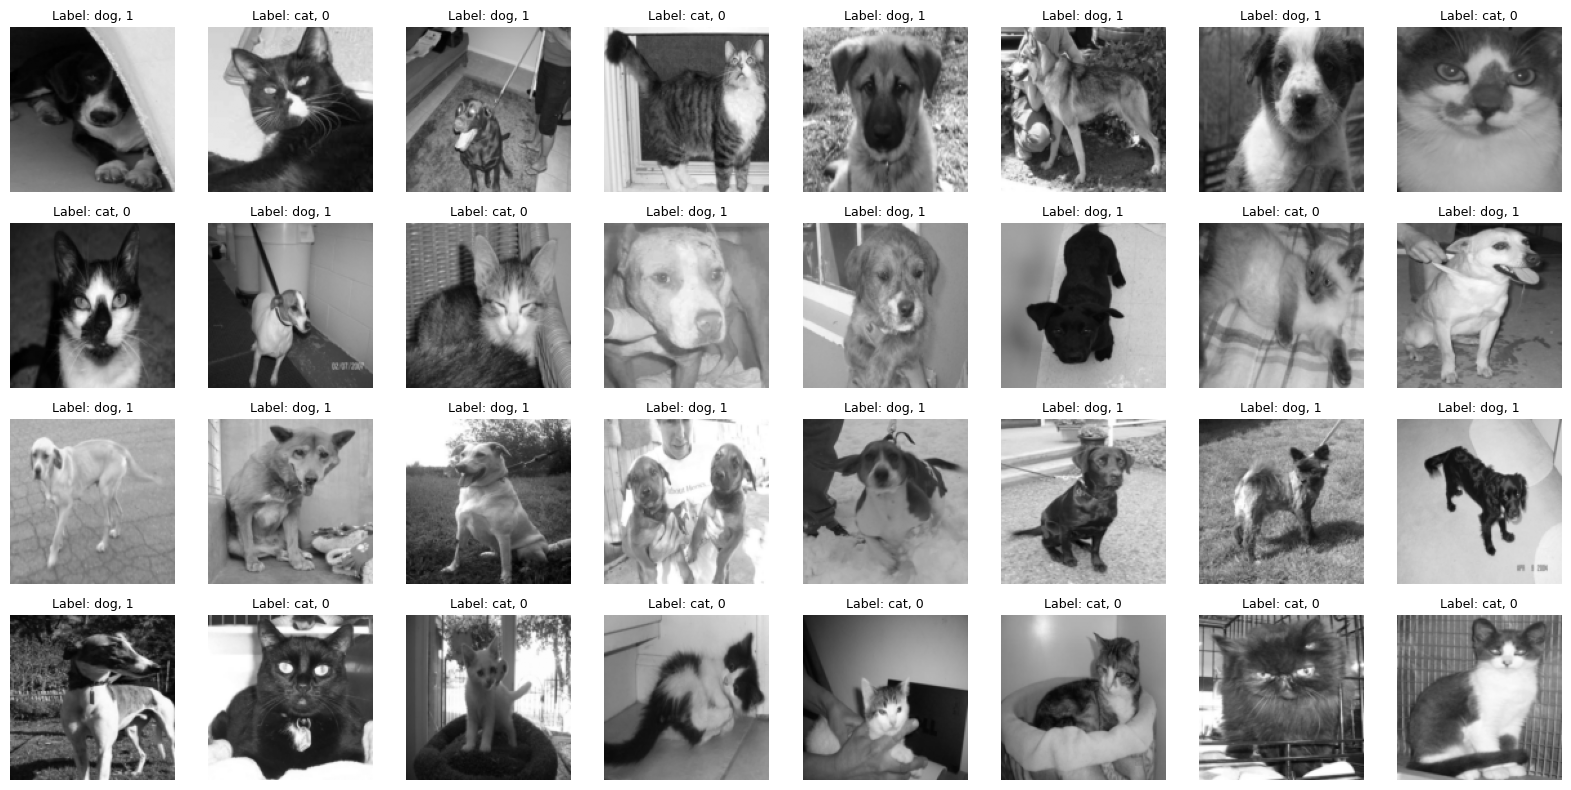

In [10]:
image, label = next(iter(test_loader))
description = label_map[label.to(int)]
show_selected_images_labels(image,label,description, rows=4, cols=8)

Erkenntnisse und Hinweise
===
- Der Datensatz wirkt vielfältig: verschiedene Auflösungen, Blickwinkel und Posen.
- Manche Bilder sind eindeutig, andere schwerer zu klassifizieren – z. B. durch schlechte Qualität oder störende Objekte. Perfekte Klassifikation sollten wir daher nicht erwarten.

Zusätzliche Überlegungen
---
- Bildvorverarbeitung verbessern: z. B. durch Skalierung, Zuschnitt oder Normalisierung.
- Datensatz ausbalancieren: Falls Klassen ungleich vertreten sind, können Over-/Undersampling-Techniken helfen.



Die Bayessche Perspektive – Wie definieren wir unseren Klassifikator?
===
Beginnen wir mit der Aufgabenstellung:
> Gegeben ein *einzelnes* Bild eines Haustiers, wollen wir klassifizieren, ob es eine Katze oder ein Hund ist.

Mathematisch:
> Gegeben ein Bild $x \in \mathbb{R}^{\text{Breite} \times \text{Höhe}}$, möchten wir die Wahrscheinlichkeiten  
$\mathbb{P}(x \text{ zeigt eine Katze})$ und $\mathbb{P}(x \text{ zeigt einen Hund})$ schätzen.  
Da jedes Bild entweder eine Katze oder einen Hund zeigt, reicht es, $p = \mathbb{P}(x \text{ zeigt einen Hund})$ zu bestimmen. Dann gilt automatisch:  
$\mathbb{P}(x \text{ zeigt eine Katze}) = 1 - p$

Noch mathematischer:
> Wir möchten eine Funktion $f: \mathbb{R}^{\text{Breite} \times \text{Höhe}} \to [0,1]$ lernen, sodass  
$f(x) \approx \mathbb{P}(x \text{ zeigt einen Hund})$

Warum Wahrscheinlichkeiten?
---
Stell dir eine Münze vor, die statt Kopf oder Zahl entweder eine Katze oder einen Hund zeigt.  
Wenn wir "die Münze werfen", wählen wir zufällig ein Bild. Was ist die Wahrscheinlichkeit, dass es einen Hund zeigt?

Antwort: Wir können das aus dem Datensatz schätzen – zähle die Hundebilder und teile durch die Gesamtanzahl.

In [7]:
labels = np.array(dataset.targets)

N = len(labels) # number of images in the dataset
dog_count = (labels == 1).sum() # number of dogs (by convention dogs have the label 1)
p_dog = dog_count / N
display(f"The probability of a randomly chosen image showing a dog is {100 * p_dog:.2f}%.")

'The probability of a randomly chosen image showing a dog is 50.00%.'

Nun stellen wir uns vor, wir „werfen die Münze“ erneut und wählen ein weiteres Haustier namens Alice. Bevor wir sie sehen, wissen wir jetzt, dass die Wahrscheinlichkeit 50 % beträgt, dass sie ein Hund ist.

Aber jetzt *sehen* wir Alice – sie ist groß, hat ein großes Maul – und unsere vorherige Einschätzung ändert sich. Mit diesen Informationen erscheint es unsinnig, immer noch eine 50-prozentige Wahrscheinlichkeit anzunehmen, dass Alice ein Hund ist, oder?

Wahrscheinlichkeitsaktualisierung
---
Zuvor hatten wir $\mathbb{P}(\text{ein Bild zeigt einen Hund}) \approx 0{,}50$ geschätzt – ohne ein konkretes Bild zu betrachten. Jetzt haben wir ein bestimmtes Bild $x \in \mathbb{R}^{\text{Breite} \times \text{Höhe}}$, sagen wir ein Bild von Alice. Wir möchten die Wahrscheinlichkeit berechnen, dass Alice ein Hund ist, **gegeben dieses Bild**:
$$
\mathbb{P}(\text{Alice ist ein Hund} \mid \text{Bild } x \text{ von Alice}) = ?
$$

Das Symbol $$\mid \text{ Bild } x \text{ von Alice}$$ bedeutet: Wir haben zusätzliche Information – nämlich das Bild.

Hinweise:
- Wir unterscheiden zwischen „Alice ist ein Hund“ (eine objektive Tatsache) und „wir glauben, dass Alice ein Hund ist“ (eine probabilistische Schätzung).
- Fehlklassifikation ist möglich, z. B. durch unscharfe Bilder – eine realistische Fehlerquelle.

Neuronale Netzwerke ins Spiel bringen
---
Wie würden wir als Menschen entscheiden, ob Alice ein Hund ist, wenn wir ihr Bild sehen? Wir würden das schließen anhand von: Schwanz, Ohren, …

> Es gibt gewisse Merkmale in Bildern, die nur zu einer der beiden Klassen gehören.

Anstatt diese Merkmale manuell zu definieren (was ineffektiv sein kann), möchten wir, dass **das Netzwerk sie lernt**.

Erinnerst du dich an die Funktion $f(x) \approx \mathbb{P}(x \text{ zeigt einen Hund})$?  
Unsere Funktion $f(x)$ ist genau das **neuronale Netzwerk**. Und weil wir elegante Symbole mögen, schreiben wir statt $f(x)$:
$$
\mathcal N_\theta(x) \approx \mathbb{P}(x \text{ zeigt einen Hund})
$$

Convolutional Neural Networks (CNNs)
---
Unser Netzwerk $\mathcal N_\theta(x)$ erhält ein Bild $x \in \mathbb{R}^{\text{Breite} \times \text{Höhe}}$ als Eingabe und gibt eine Wahrscheinlichkeit in $[0,1]$ zurück.  
Convolutional Neural Networks sind genau diese Art von Netzwerken, die ein ganzes Bild auf eine einzelne Zahl reduzieren können.

In [8]:
# Here we define the sketch of our (convolutional) neural network
use_sigmoid = False
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # These are convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                            

            nn.Conv2d(32, 64, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                            

            nn.Conv2d(64, 128, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                             
        )

        # These are fully connected layers
        if use_sigmoid:
            self.fc_layers = nn.Sequential(
                nn.Flatten(),                                
                nn.Linear(128 * 13 * 13, 32),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Linear(32, 1),
                nn.Sigmoid()                                  
            )
        else:
            self.fc_layers = nn.Sequential(
                nn.Flatten(),                                
                nn.Linear(128 * 13 * 13, 32),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Linear(32, 1),
                # the sigmoid is now included in the loss function for numerical stability
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Here we instantiate the neural network
neural_network = NeuralNetwork().to(device)

Die Sigmoid-Funktion
---
Die letzte Funktion unseres Netzwerks ist die sogenannte **Sigmoid-Funktion**:
$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$

Sie bildet also von $\mathbb R$ auf $[0,1]$ ab – $\sigma(t)$ kann als Wahrscheinlichkeit interpretiert werden!

Wichtig: $t \in \mathbb R$ repräsentiert **kein Bild**, sondern ist bereits ein Zwischenergebnis unseres Netzwerks, nachdem das Eingabebild $x$ zu einer reellen Zahl $t$ transformiert wurde. Danach wird $\sigma(t)$ angewendet, um eine Ausgabe in $[0,1]$ zu erhalten.

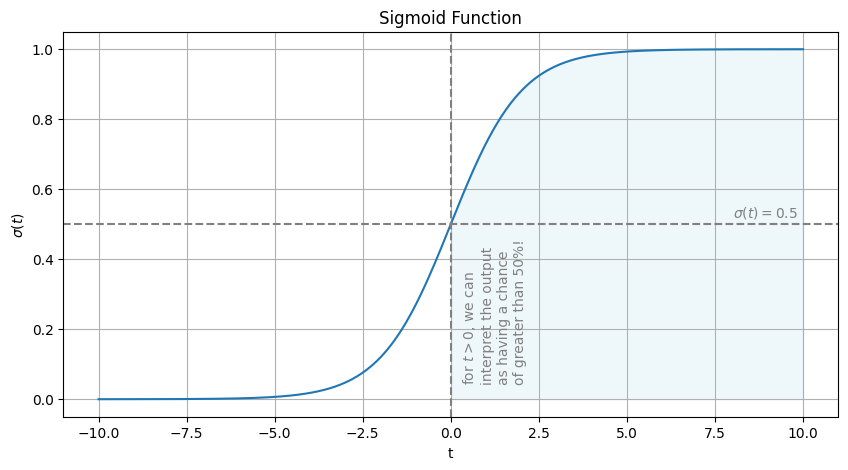

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Input range
t = np.linspace(-10, 10, 1000)
y = sigmoid(t)

# Plot
plt.figure(figsize=(10,5))
plt.plot(t, y)
plt.title("Sigmoid Function")
plt.xlabel("t")
plt.ylabel(r"$\sigma(t)$")
plt.grid(True)
plt.axhline(0.5, color='gray', linestyle='--')  # Midline
plt.axvline(0, color='gray', linestyle='--')    # Center point

# Annotate horizontal line
plt.text(8, 0.52, r"$\sigma(t)=0.5$", color='gray', fontsize=10)

# Annotate vertical line
plt.text(0.3, 0.05, 'for $t > 0$, we can \ninterpret the output \nas having a chance \nof greater than 50%!', color='gray', fontsize=10, rotation=90)

plt.fill_between(t, y, where=(t >= 0), color='lightblue', alpha=0.2, label=r'Area: $x \geq 0$')


plt.show()

Test des neuronalen Netzwerks *vor dem Training*
---
Wir können bereits einige Bilder in unser neuronales Netzwerk einspeisen und die Ausgabe inspizieren – auch bevor wir es trainiert haben. Diese Ausgaben sind anfangs zufällig, da das Netzwerk noch nichts über Hunde und Katzen gelernt hat.

Um die "Performance" unsseres Netzwerkes zu bestimmen, definieren wir ein Maß für die Genauigkeit als Verhältnis der richtig klassifizierten Bilder zu den gesamten Bildern in einem zweiten "Testdatensatz".
$$
\text{accuracy} = \frac{\text{\# correctly classified}}{\text{\# total}}
$$

In [10]:
# Here we define our accuracy function
decision_threshold = 0.5 if use_sigmoid else 0.0
def accuracy(model):
    # First we load a predefined set of test images and labels
    image, label = next(iter(test_loader))
    y_true = label.detach().cpu().numpy().squeeze()

    # Here we evaluate the model output on the test images
    with torch.no_grad():
        y_pred = (model(image.to(device)).detach().cpu().numpy() > decision_threshold).squeeze().astype(int)
    
    acc = (y_pred == y_true).mean()
    
    return acc, y_true, y_pred, image

# Just some visualisation
def eval_model(model):
    model.eval()

    acc, y_true, y_pred, image = accuracy(neural_network)
    
    visualize_predictions(image, y_true, y_pred, rows=4, cols=8)

    true_count = y_true == y_pred
    false_count = y_true != y_pred
    print("Correctly classified: ", np.sum(true_count))
    print("Wrongly classified: ", np.sum(false_count))
    print("Accuracy: ", acc)

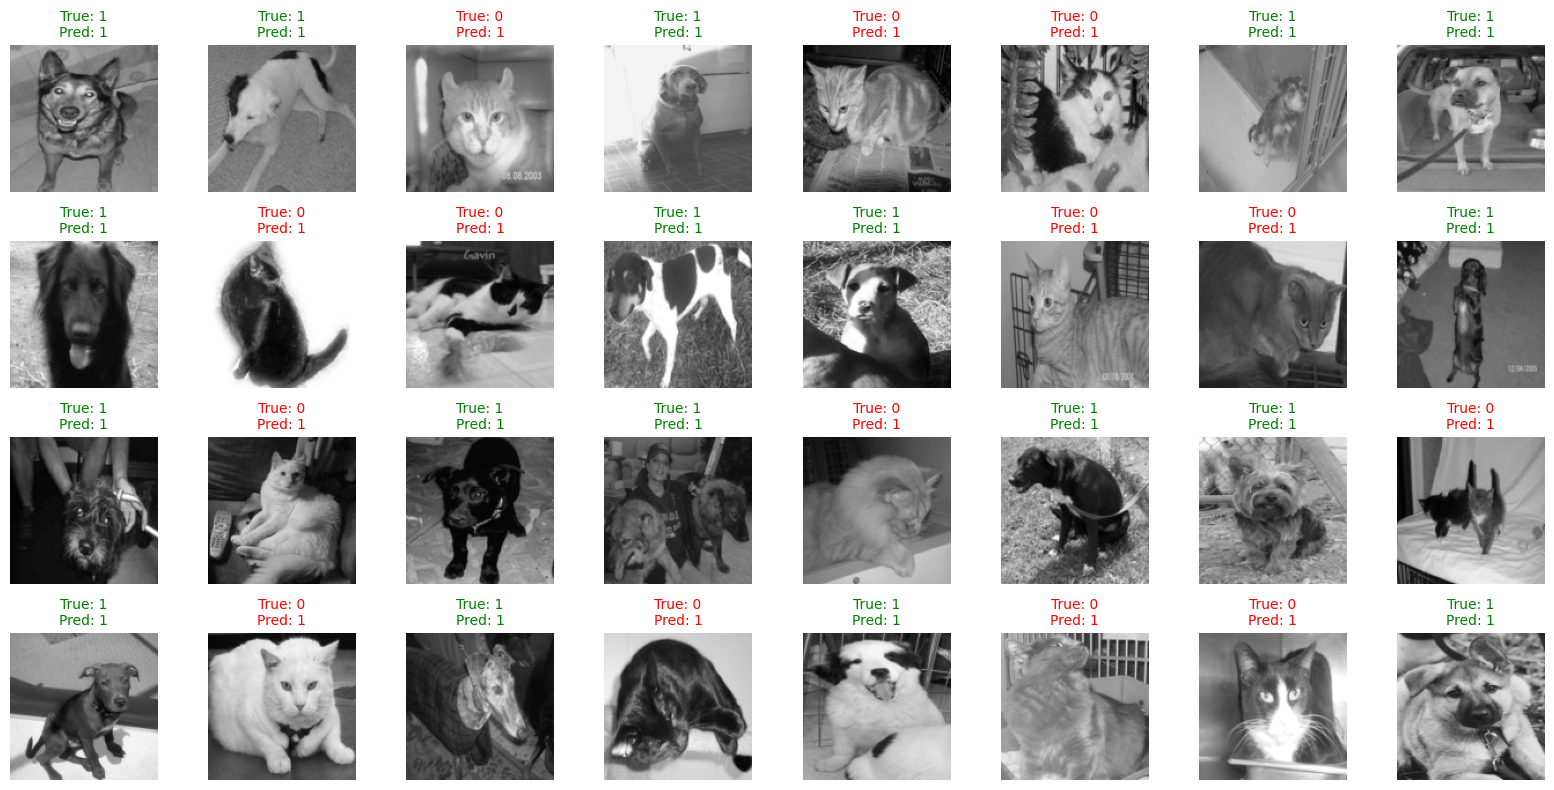

Correctly classified:  18
Wrongly classified:  14
Accuracy:  0.5625


In [11]:
eval_model(neural_network)

Training unseres neuronalen Netzwerks
===

Bisher sieht es nicht so aus, als würde unser Netzwerk irgendetwas darüber „wissen“, wie man Haustiere korrekt klassifiziert. Vielmehr scheint es den Typ zufällig zu raten. Wir müssen dem Netzwerk irgendwie beibringen, wie Katzen und Hunde aussehen.

Lernen durch Beispiele
---
Wie hast du „gelernt“, wie ein Hund aussieht? Ich vermute, du hast schon genug Hunde gesehen, um zu wissen, wie sie aussehen. Aber das allein reicht nicht. Als du wirklich etwas über Haustiere gelernt hast, etwa „Das ist Alice. Sie ist ein Hund.“, hast du durch gelabelte Daten gelernt (du hast Alice zusammen mit einer Beschreibung gesehen) und konntest dann auf neue Haustiere verallgemeinern. Genau das machen wir jetzt mit unserem neuronalen Netzwerk.


In [12]:
# Here we define our loss function
if use_sigmoid:
    loss_func = nn.BCELoss().to(device)
else:
    # here we still use the sigmoid but it is hidden in the loss function
    loss_func = nn.BCEWithLogitsLoss().to(device)

# We tell the optimisation algorithm what parts of our neural network are trainable
pars = neural_network.parameters()
optimizer = torch.optim.Adam(pars, lr=0.0009, weight_decay=1e-5)

Die Verlustfunktion
===

Wir haben die Konvention, dass eine 0 für Katzen und eine 1 für Hunde steht. Das sind lediglich **Labels** und keine Wahrscheinlichkeiten!  
Da unser Netzwerk jedoch die Wahrscheinlichkeit $\mathcal N_\theta(x) \approx \mathbb{P}(x \text{ zeigt einen Hund})$ ausgibt, die **nahe bei 0** liegen sollte, wenn $x$ eine Katze zeigt, und **nahe bei 1**, wenn $x$ ein Hund ist, können wir die Bedeutung von Labeln und Wahrscheinlichkeiten miteinander in Beziehung setzen.

Wenn wir ein Paar $(x, l)$ haben, wobei $x$ ein Bild ist (z. B. von Alice) und $l$ das zugehörige Label ist — entweder 0 für Katze oder 1 für Hund —, dann möchten wir minimieren:
$$
|\mathcal N_\theta(x) - l|.
$$
um die Netzwerkausgabe möglichst nah an das wahre Label $l$ des Bildes $x$ zu bringen.

Wenn wir mehrere solcher Bild-Label-Paare haben, z. B. $(x_1, l_1), (x_2, l_2)$, dann möchten wir minimieren:
$$
|\mathcal N_\theta(x_1) - l_1| + |\mathcal N_\theta(x_2) - l_2|.
$$
Dabei könnte $x_1$ ein Bild von Alice sein, von der wir wissen, dass $l_1 = 1$ ist, und $x_2$ ein Bild eines anderen Haustiers, z. B. Bob, bei dem $l_2 = 0$ gilt, was bedeutet, dass Bob eine Katze ist.

Natürlich haben wir **mehr als nur zwei Bilder** zum Trainieren!  
In kompakter Notation schreiben wir:
$$
\min \sum_{i = 1, 2, \dots, N} |\mathcal N_\theta(x_i) - l_i|
$$

Fortgeschritten: Umschreiben der Verlustfunktion
---

Da die Ausgabe unseres Modells $\mathcal N_\theta(x)$ zwischen 0 und 1 liegt, würde der Logarithmus $-\infty$ ergeben, wenn wir uns sehr sicher sind, dass $x$ eine Katze ist, und 0, wenn wir sicher sind, dass $x$ ein Hund ist. Das möchten wir genauer untersuchen.

Angenommen, $x$ ist eine Katze, also ist $l = 0$. Dann betrachten wir die beiden Terme
- $-l \cdot \log \mathcal N_\theta(x)$ und
- $-(1 - l) \cdot \log (1 - \mathcal N_\theta(x))$.

Wenn unser Netzwerk gute Arbeit leistet, sodass $\mathcal N_\theta(x) \approx 0$, sind beide Terme klein (überprüfe das gerne selbst!). Wenn das Netzwerk jedoch schlecht arbeitet, wird der zweite Term sehr groß.

Nun nehmen wir an, dass $x$ ein Hund ist, also $l = 1$, und betrachten erneut dieselben Terme:
- $-l \cdot \log \mathcal N_\theta(x)$,
- $-(1 - l) \cdot \log (1 - \mathcal N_\theta(x))$.

Wenn unser Netzwerk nun richtig klassifiziert, d. h. $\mathcal N_\theta(x) \approx 1$, sind wieder beide Terme klein. Wenn es falsch liegt, wird diesmal der erste Term groß!

In der Praxis führt das zur folgenden Verlustfunktion, die als *binäre Kreuzentropie* bezeichnet wird:
$$
\min \sum_{i = 1, 2, \dots, N} -l_i \cdot \log \mathcal N_\theta(x_i) - (1 - l_i) \cdot \log (1 - \mathcal N_\theta(x_i))
$$

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?batches/s]

/home/hoeflerm/.local/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2:   0%|          | 0/391 [00:00<?, ?batches/s]

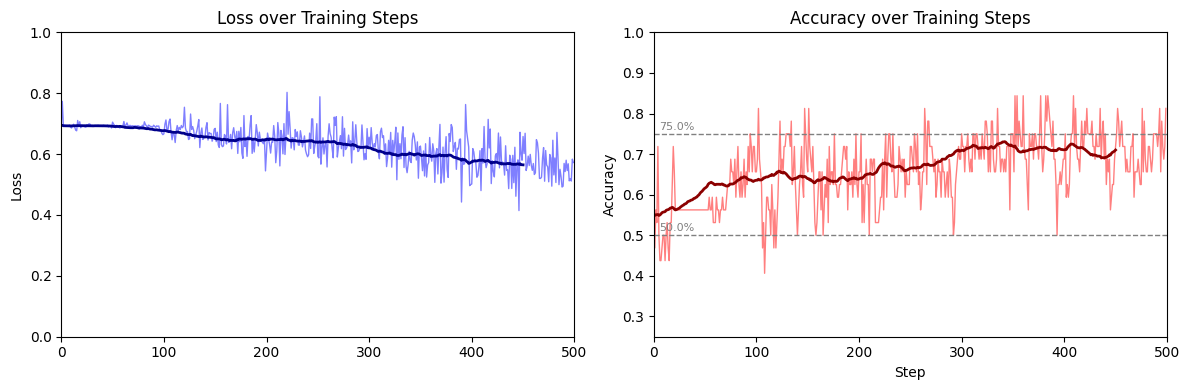

Epoch 3:   0%|          | 0/391 [00:00<?, ?batches/s]

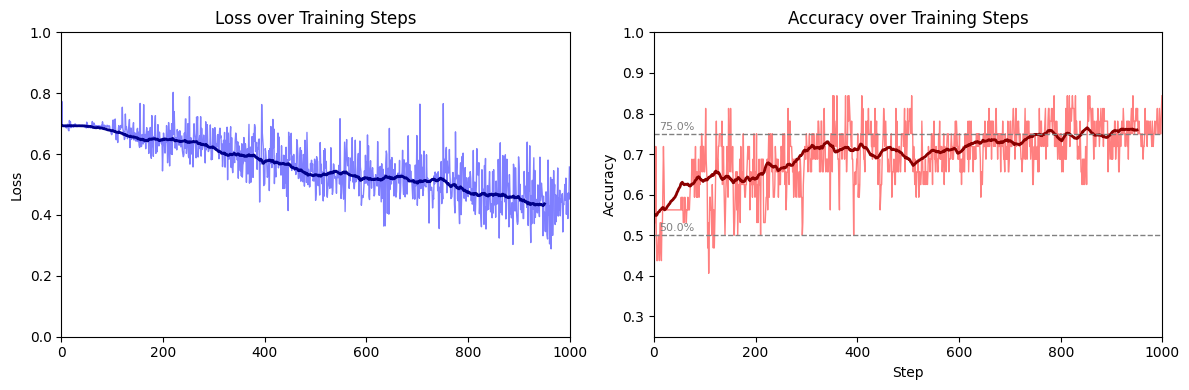

Epoch 4:   0%|          | 0/391 [00:00<?, ?batches/s]

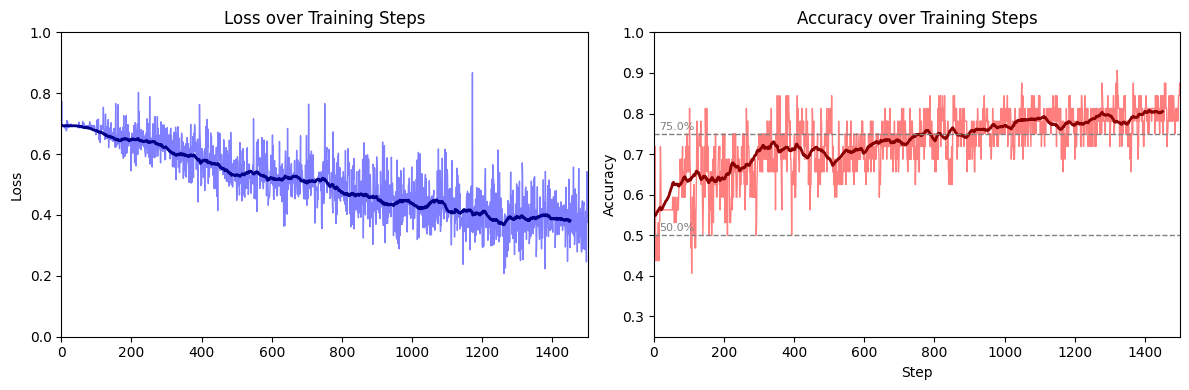

Epoch 5:   0%|          | 0/391 [00:00<?, ?batches/s]

Epoch 6:   0%|          | 0/391 [00:00<?, ?batches/s]

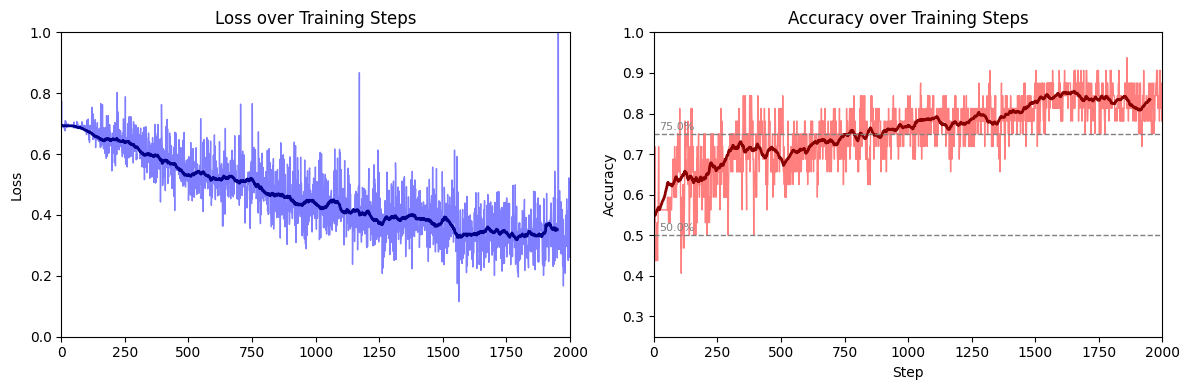

Epoch 7:   0%|          | 0/391 [00:00<?, ?batches/s]

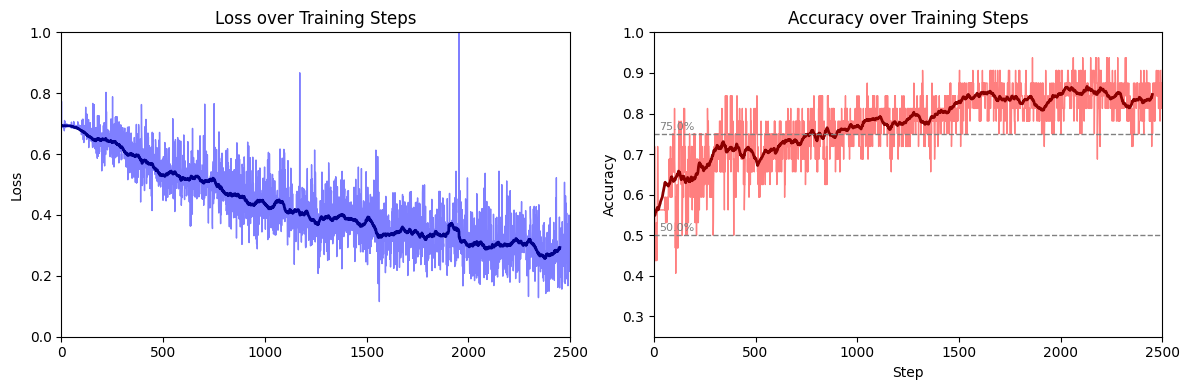

Epoch 8:   0%|          | 0/391 [00:00<?, ?batches/s]

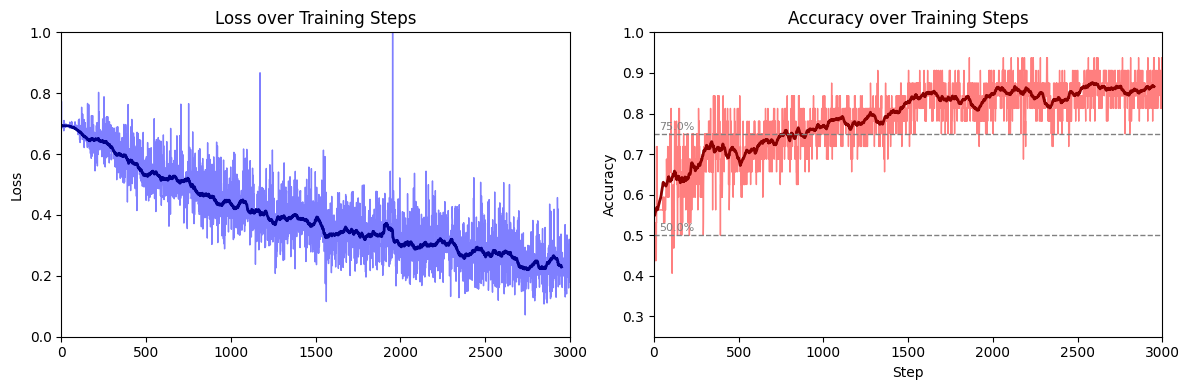

Epoch 9:   0%|          | 0/391 [00:00<?, ?batches/s]

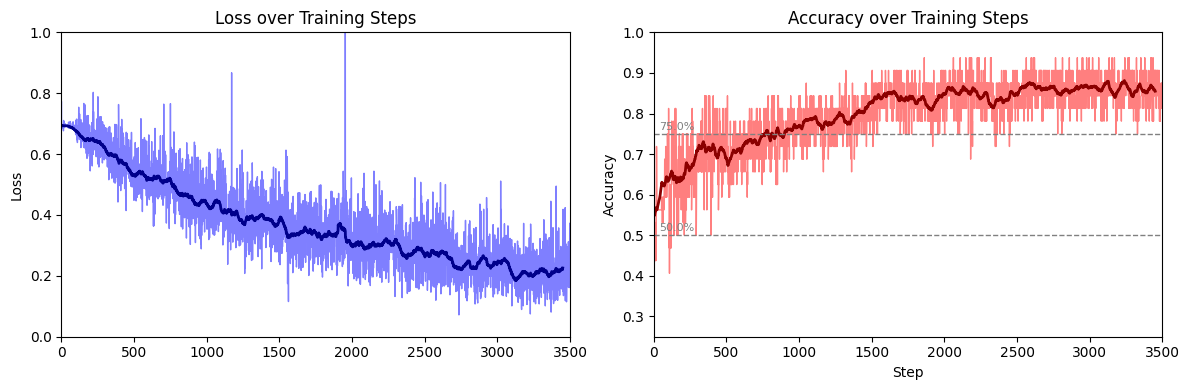

Epoch 10:   0%|          | 0/391 [00:00<?, ?batches/s]

Finished Training


In [13]:
# Some uninteresting setup code
epochs = 10
show_every=500

steps_per_epoch = len(train_loader)
ob_val = np.zeros(epochs*steps_per_epoch)
acc = np.zeros(epochs*steps_per_epoch)

epoch_bar = trange(epochs, desc="Epochs", leave=True) # just a fancy progress bar

i = 0

# The actual training of our neural network
neural_network.train() # set to training mode

# In each epoch, we loop over the whole dataset of approximately 20.000 images and labels
for epoch in epoch_bar:  

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batches", leave=False) # another fancy progress bar

    # Here we loop once over the whole dataset
    for images, labels in pbar:

        images = images.to(device)
        labels = labels.to(device)

        # start a new optimisation step
        optimizer.zero_grad()

        # Evaluate the loss and carry out gradient descent step
        loss = loss_func(neural_network(images).squeeze(),labels.to(torch.float32))
        loss.backward()

        # apply the update
        optimizer.step()


        
# Just some more uninteresting code
        # print loss
        ob_val[i] = loss.item()
        acc[i] = accuracy(neural_network)[0]

        pbar.set_postfix(loss=f"{ob_val[i]:.4f}", accuracy=f"{acc[i]:.4f}")

        if np.remainder(i,show_every)==0 and i > 0:
            plot_loss(ob_val[:i], acc[:i])
            plt.pause(0.001)

        i += 1
        avg_loss = ob_val[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch].mean()
        avg_acc = acc[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch].mean()
    epoch_bar.set_postfix(avg_loss=f"{avg_loss:.4f}", accuracy=f"{avg_acc:.4f}")

print('Finished Training')

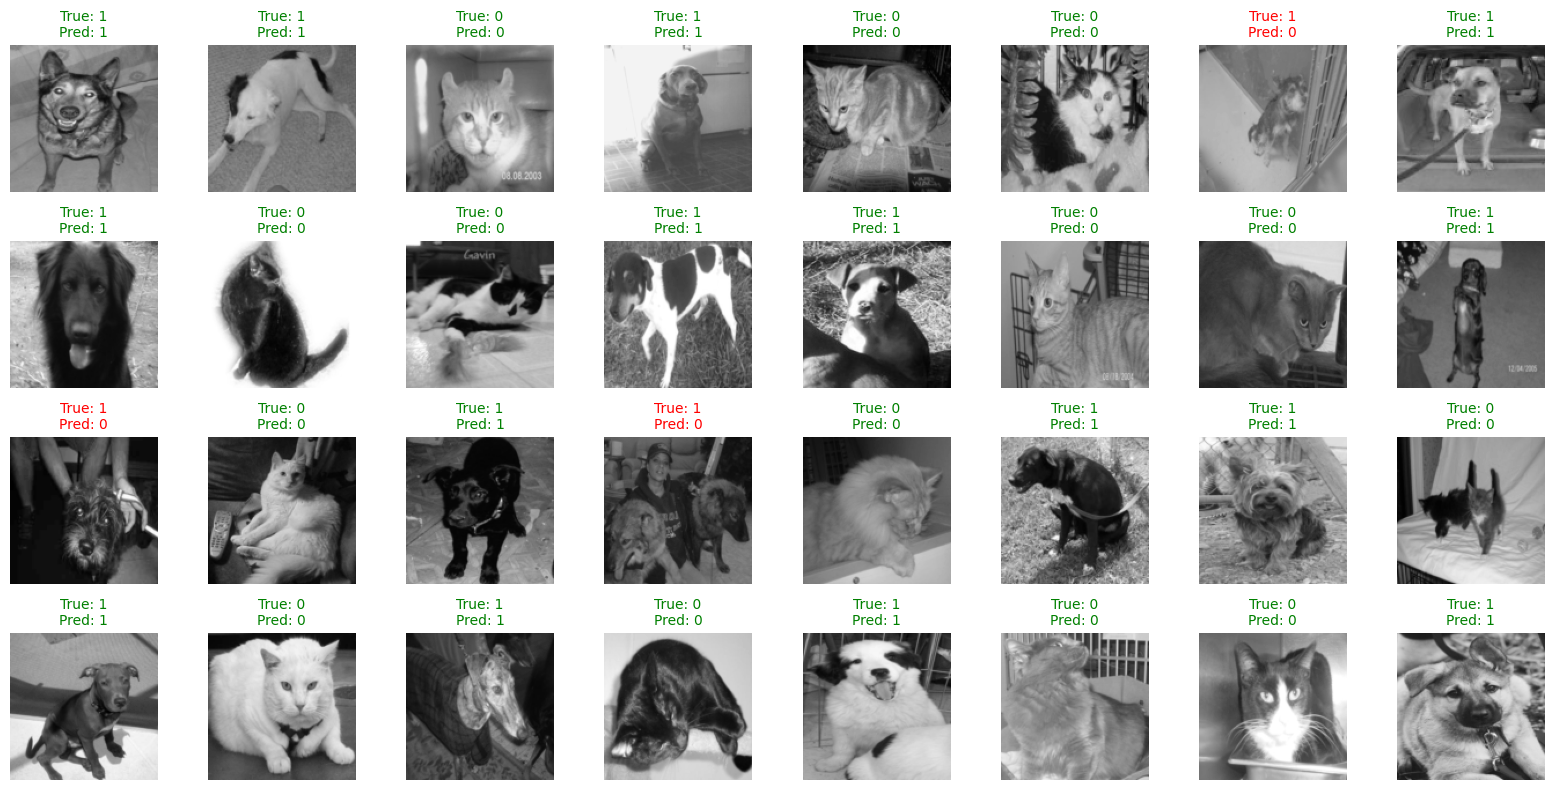

Correctly classified:  29
Wrongly classified:  3
Accuracy:  0.90625


In [14]:
# Make a post training check to see how our model has improved
eval_model(neural_network)